# Trying to load a dataset

In [1]:
import torchvision
import torch
from torchinfo import summary
from torchvision.models.detection.ssdlite import SSDLite320_MobileNet_V3_Large_Weights


num_classes = 2 # 0=ball, 1=player

# load a model, where the backbone is already trained, and the output layers aren't (at least, this should be the case...)
# also set the number of output classes to the number we need
model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(weights=None, num_classes=num_classes, weights_backbone=True)


# freeze all layers, except the output heads
for param in model.parameters():
    param.requires_grad = False
for param in model.head.parameters():
    param.requires_grad = True 


summary(model=model,   # can also look at "model=trained_model"
        input_size=(1, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)


c:\Users\danie\miniconda3\envs\footballtracking\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\danie\miniconda3\envs\footballtracking\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights_backbone=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights_backbone=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type (var_name))                                                Input Shape          Output Shape         Param #              Trainable
SSD (SSD)                                                              [1, 3, 224, 224]     [143, 4]             --                   Partial
├─GeneralizedRCNNTransform (transform)                                 [1, 3, 224, 224]     [1, 3, 320, 320]     --                   --
├─SSDLiteFeatureExtractorMobileNet (backbone)                          [1, 3, 320, 320]     [1, 128, 1, 1]       --                   False
│    └─Sequential (features)                                           --                   --                   --                   False
│    │    └─Sequential (0)                                             [1, 3, 320, 320]     [1, 672, 20, 20]     (869,096)            False
│    │    └─Sequential (1)                                             [1, 672, 20, 20]     [1, 960, 10, 10]     (2,102,856)          False
│    └─ModuleList

# Load the Datasets

In [2]:
from torch.utils.data import DataLoader
from src.dataLoading import playersDataset, collate_fn   # these are custom for our dataset


# set the device (GPU is much faster)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_workers = 1 if torch.cuda.is_available() else 0
batch_size = 16 # LOWER THIS IF NEEDED!

train_dir = "Data/train/"
valid_dir = "Data/valid/"
test_dir = "Data/valid/"
train_dataset = playersDataset(train_dir)
validation_dataset = playersDataset(valid_dir)
test_dataset = playersDataset(test_dir)

# Define the dataloaders for each set
train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn)
val_loader = DataLoader(validation_dataset, batch_size=batch_size, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)

In [14]:
#test_dataset[0][1]

# Training Loop
mostly just me trying to see if a training loop works (this absolutely needs changing, bits and pieces are copied off the internet and they do not work well together, but at least the inputs and outputs seem to work)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm

model.to(device)


# these need changing, probably
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
num_epochs = 25

def train_model(model, criterion, optimizer, scheduler=None, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = np.inf
    losses_train = []
    accuracies = []
    losses_val = []
    accuracies_val = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            datasetSize = None
            if phase == 'train':
                model.train()  # Set model to training mode
                dataSource = train_loader
                dataset_size = len(train_dataset)
                print("TRAIN")
            else:
                model.train()
                # model.eval()   # Set model to evaluate mode
                dataSource = val_loader
                dataset_size = len(validation_dataset)
                print("EVAL")

            running_loss = 0.0
            running_classification_loss = 0.0
            running_bounding_box_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i, (images, targets) in enumerate(tqdm(dataSource)):

                # zero the parameter gradients
                optimizer.zero_grad()

                # send both the input images and output targets to the device
                images = list(image.to(device) for image in images)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    loss_dict = {}
                    if(phase == 'train'): 
                        loss_dict = model(images, targets)
                    elif(phase == 'val'):
                        with torch.no_grad():
                            loss_dict = model(images, targets)
                    # print(loss_dict)
                    losses = sum(loss for loss in loss_dict.values())  # sum the loss for all images of this epoch

                    # print(losses)
                    running_loss += float(losses)
                    running_classification_loss += loss_dict['classification']
                    running_bounding_box_loss += loss_dict['bbox_regression']


                    # backward + optimize only if in training phase
                    if phase == 'train':
                        losses.backward()
                        optimizer.step()

            if(phase == 'train' and scheduler != None):
                scheduler.step()

            epoch_loss = running_loss / dataset_size
            classification_loss = running_classification_loss / dataset_size
            bounding_box_loss = running_bounding_box_loss / dataset_size

            if(phase == 'train'):
                losses_train.append(epoch_loss)
                # accuracies.append(epoch_acc)
            elif(phase == 'val'):
                losses_train.append(epoch_loss)
                # accuracies_val.append(epoch_acc)
            print(f'{phase} Loss: {epoch_loss:.4f}. Classification Loss: {classification_loss:.4f}. Bounding Box Loss: {bounding_box_loss:.4f}')
            
            # if phase == 'val' and epoch_acc > best_acc:
            #     best_acc = epoch_acc
            #     best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val' and epoch_loss < best_loss:
                print(f'Best loss value epoch {epoch}')
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    # print(f'Best val Acc: {best_acc:4f}')
    # load best model weights
    # model.load_state_dict(best_model_wts)
    return model, losses_train, accuracies, losses_val, accuracies_val

In [6]:
model, losses, accuracies, losses_val, accuracies_val = train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs)

Epoch 0/24
----------
TRAIN


 14%|█▍        | 12/84 [00:07<00:42,  1.70it/s]


KeyboardInterrupt: 

## EVALUATION

In [9]:
from Evaluation.engine import evaluate

evaluator = evaluate(model, test_loader, device)
# its probably possible to supress some of these print messages if we wanted to. 
# the last line of this function just prints the AP stuff, could be put under an if condition

creating index...
index created!
Test:  [ 0/28]  eta: 0:00:41  model_time: 0.2058 (0.2058)  evaluator_time: 0.6179 (0.6179)  time: 1.4901  data: 0.3491  max mem: 778
Test:  [27/28]  eta: 0:00:00  model_time: 0.1347 (0.1385)  evaluator_time: 0.4209 (0.4765)  time: 0.9349  data: 0.3308  max mem: 778
Test: Total time: 0:00:27 (0.9942 s / it)
Averaged stats: model_time: 0.1347 (0.1385)  evaluator_time: 0.4209 (0.4765)
Accumulating evaluation results...
DONE (t=0.45s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.

In [13]:
evaluator.summarize()

IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.032


## Bonus: function to see if the bounding boxes and labels are alright:

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_imgs(imgs, annotations, true_annotations, rows, cols, tensors=False):
    CLASSES = ["ball", "player"]
    fig = plt.figure(figsize=(20,10))
    
    for i in range(len(imgs)):
        ax = fig.add_subplot(rows, cols, i + 1, xticks=[], yticks=[])

        boxes = annotations[i]['boxes']
        true_boxes = true_annotations[i]['boxes']
        labels = annotations[i]['labels']
        scores = annotations[i]['scores']
        img = None
        if(tensors):
            img = imgs[i].cpu().numpy().transpose(1, 2, 0)
        else:
            img = imgs[i].numpy().transpose(1, 2, 0)
        ax.imshow(img, origin='upper')

        for j, (box, score) in enumerate(zip(boxes, scores)):
            if(score < 0.25):
                continue
            top, left = int(box[0]), int(box[1])
            width = int(box[2] - box[0])
            height = int(box[3] - box[1])

            #top, left, width, height = [448*i for i in boxes[i][0:]]
            rect = patches.Rectangle((top, left), width, height, edgecolor='r', facecolor='none', linewidth=2.0)
            ax.add_patch(rect)

            ax.text(top, left, CLASSES[int(labels[j])], horizontalalignment='left', verticalalignment='bottom', color='white', weight='bold')
        
        for j, box in enumerate(true_boxes):
            top, left = int(box[0]), int(box[1])
            width = int(box[2] - box[0])
            height = int(box[3] - box[1])

            #top, left, width, height = [448*i for i in boxes[i][0:]]
            rect = patches.Rectangle((top, left), width, height, edgecolor='b', alpha=0.3, facecolor='none', linewidth=2.0)
            ax.add_patch(rect)

            # ax.text(top, left, CLASSES[int(labels[j])], horizontalalignment='left', verticalalignment='bottom', color='white', weight='bold')

    plt.show()

ValueError: num must be 1 <= num <= 16, not 17

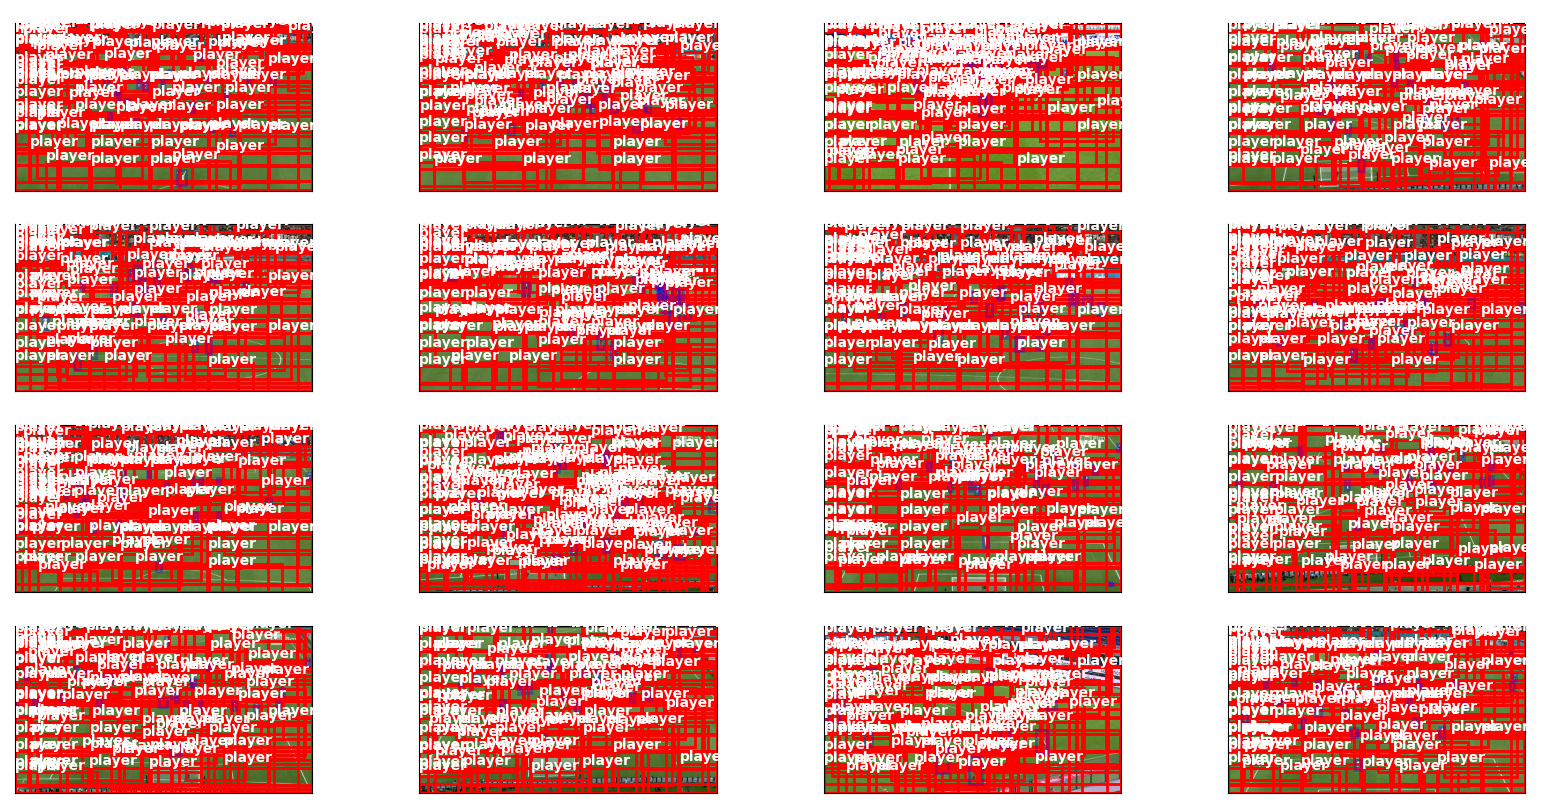

In [6]:
model.eval()
images, targets = next(iter(test_loader))
images = list(image.to(device) for image in images)
preds = model(images)
fig = visualize_imgs(images, preds, targets, rows=4, cols=4, tensors=True)